# ``ConvNet2d`` Demo

The ``torch_tools.ConvNet2d`` model is—believe it or not—a two-dimensional convolutional neural network. The model consists of three modular components:

- an encoder, which can be optionally set to any of ``torchvision``'s ResNet or VGG models.
- an adaptive pooling layer, which can be optionally set to adaptive average pooling, max pooling, or a concatenation of both.
- a fully-connected final block, which is simply a customisable instance of ``torch_tools.DenseNetwork``.

The main useful features of the model are:
- the ability to set the number of input channels images should have at instantiation, which you cannot do with out-of-the-box ``torchvision`` models.
    - note—this comes with the caveat that freezing the pretrained weights becomes pointless, as the first ``conv2d`` layer of the encoder is overloaded to account for the different number of channels.
- the ability to load the model with ``torchvision``'s ImageNet-pretrained weights, and do transfer learning with/without the pretrained weights frozen.

## Classifying handwritten digits — MNIST

The MNIST dataset contains greyscale images of `(28,28)` pipxels containing handwritten digits between zero and nine. It is very easy to access the MNIST data through ``torchvision``—so much so that we don't even need to use the custom ``torch_tools.DataSet`` class.

So, let's get some digits!
(Note: )

In [19]:
from torchvision.datasets import MNIST
from torch import eye
from torchvision.transforms import Compose, ToTensor

import matplotlib.pyplot as plt

train_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=True,
    transform=Compose([ToTensor(), lambda x: x.repeat(3, 1, 1)]),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

valid_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=False,
    transform=Compose([ToTensor(), lambda x: x.repeat(3, 1, 1)]),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

print(len(train_set), len(valid_set))

60000 10000


Since we have done quite a few things here, let's break them down.

- The ``transform`` argument:
  - we supply a ``torchvision.transfroms.Compose`` object, which simply lets you chain callable objects to modify the images.
  - the first thing in the ``Compose`` is a ``torchvision.transforms.ToTensor``, which converts PIL images (or numpy image-like arrays) to ``torch.Tensor``s.
  - the second thing is the lambda function, which simply repeats the greyscale ``Tensor`` three times along the channel dimension. We do this because we are going to use a pretrained model which requires three input channels.
- The ``target_transform`` argument:
  - The target for each image is simply encoded as an integer. ``0`` means the image contains a zero, ``1`` means the image contains a one, etc. We convent these indices to one-hot encoded vectors with the lambda function supplued to ``target_transfrom``.

Let's look at a single example.

torch.Size([3, 28, 28]) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


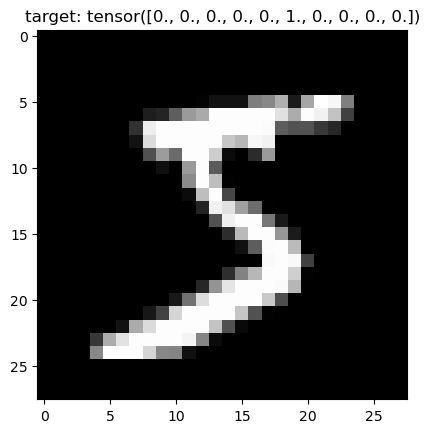

In [20]:
for img, target in train_set:
    print(img.shape, target)

    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"target: {target}")
    plt.show()
    break

This example is clearly a five, and the target is a one-hot vector encoding the fact that the ground truth is a five.

As before, we now wrap the datasets in ``torch.utils.data.DataLoader``.

In [21]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

As before, we need a model, optimiser and a loss function.

In [22]:
from torch_tools import ConvNet2d

model = ConvNet2d(
    out_feats=10,
    pretrained=True,
    encoder_style="resnet18",
    dense_net_kwargs={"input_dropout": 0.1},
)
print(model)

ConvNet2d(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Here, we have instantiated a resnet18, with ImageNet-pretrained weights and applied a dropout to the classification layer.

Now, lets set up a loss function and optimiser.

In [23]:
from torch.nn import BCELoss
from torch.optim import Adam

loss_func = BCELoss(reduction="sum")
optimiser = Adam(model.parameters(), lr=1e-4)